### DS 340H: Final Project
By: Tayae Rogers \
Date: 10/25/2024

In [72]:
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform, Transformer
# from geopy.geocoders import Nominatim
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import requests
import seaborn as sns

In [4]:
os.chdir("/Users/tayaerogers/Desktop/DS340H/FinalProject")

### Reading in data

In [5]:
# Blue Bike rides
june22 = pd.read_csv('202206-bluebikes-tripdata.csv')
july22 = pd.read_csv('202207-bluebikes-tripdata.csv')
aug22 = pd.read_csv('202208-bluebikes-tripdata.csv')

bike_rides = pd.concat([june22, july22, aug22])

In [6]:
# Blue Bike stations
bike_stations = pd.read_csv('current_bluebikes_stations.csv', header=1)

In [7]:
# MBTA rides
T_rides_Q2 = pd.read_csv('TravelTimes_2022/2022-Q2_HRTravelTimes.csv')
T_rides_Q3 = pd.read_csv('TravelTimes_2022/2022-Q3_HRTravelTimes.csv')

T_rides = pd.concat([T_rides_Q2, T_rides_Q3])

In [8]:
# MBTA stations
T_stations = gpd.read_file('mbta_rapid_transit/MBTA_NODE.shp')

### Data cleaning

##### Blue Bike stations and rides

In [9]:
# Make a df of stations in Cambridge
bike_stations_cambridge = bike_stations[bike_stations['Municipality'] == 'Cambridge'].reset_index(drop=True)
bike_stations_cambridge = bike_stations_cambridge.rename(columns={'Lat':'latitude', 'Long':'longitude'})

# Make a list of stations in Cambridge
bike_stations_cambridge_ls = bike_stations_cambridge['NAME'].to_list()

# Subset to bike rides that started and ended in Cambridge
bike_rides = bike_rides[(bike_rides['start station name'].isin(bike_stations_cambridge_ls)) & (bike_rides['end station name'].isin(bike_stations_cambridge_ls))].reset_index(drop=True)

# Match column name for travel_time_sec and create travel_time_min
bike_rides = bike_rides.rename(columns={'tripduration':'travel_time_sec'})
bike_rides['travel_time_min'] = bike_rides['travel_time_sec']/60

##### T rides/trains

In [10]:
# Subset to rides taken in summer 2022
T_rides['service_date'] = pd.to_datetime(T_rides['service_date'])
T_rides = T_rides[(T_rides['service_date'] >= '2022-06-01') & (T_rides['service_date'] < '2022-09-01')].reset_index()

# Goal: Subset to T paths that start and end in Cambridge
### Method 1: Manually get list of relevant stops
### Method 2: Maybe I don't need to formally do this if I know latitude and longitude and the time it takes to walk to these stops

In [11]:
# Revise service date, start time, and end time
# Based on data source notes
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'service_date'] += datetime.timedelta(days=1)
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'start_time_sec'] -= 60*60*24
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'end_time_sec'] -= 60*60*24

In [12]:
# Make sure editing time worked
print(T_rides['start_time_sec'].describe())
print(T_rides['start_time_sec'].max() < 60*60*24)

count    8.343180e+06
mean     5.098149e+04
std      2.063619e+04
min      0.000000e+00
25%      3.463200e+04
50%      5.177200e+04
75%      6.794600e+04
max      8.639900e+04
Name: start_time_sec, dtype: float64
True


In [13]:
# Create new columns for reference
T_rides['start_time_min'] = T_rides['start_time_sec']/60
T_rides['end_time_min'] = T_rides['end_time_sec']/60

T_rides['start_time_hour'] = T_rides['start_time_min']/60
T_rides['end_time_hour'] = T_rides['end_time_min']/60

# TO DO: Something with fixing the date and time alignment
# TO DO: Merge in T_station data so I have latitude and longitude in this one dataframe at some point?

##### T stations

In [14]:
# Calculate longitude and latitude values for each coordinate geometry point
# Convert from NAD83 to regular coordinates
def convert_longLat(geo_df):
    inProj = Proj(init="epsg:26986", preserve_units=True)
    outProj = Proj(init='epsg:4326')

    long_conv, lat_conv = transform(inProj, outProj, geo_df.geometry.x, geo_df.geometry.y)

    geo_df['latitude'] = lat_conv
    geo_df['longitude'] = long_conv

    return geo_df

T_stations = convert_longLat(T_stations)
# Note: Gives me a "this function is deprecated" warning but it runs

/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_6579/285248274.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stab

### Finding closest T stop to each bike station

In [31]:
# Subsetting to T stations in Cambridge
# Note: Figure out how to do this more automatically? One option: subset to stations in Cambridge using geopy.geocoders and Nominatim
cambridge_station_ls = ['Alewife', 'Central', 'Harvard', 'Kendall/MIT', 'Porter'] 
T_stations_cambridge = T_stations[T_stations['STATION'].isin(cambridge_station_ls)]

In [32]:
T_stations_cambridge

,STATION,LINE,TERMINUS,ROUTE,geometry,latitude,longitude
56,Harvard,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231387.274 902684.016),42.374029,-71.118906
57,Kendall/MIT,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (234087.917 901406.551),42.362415,-71.086191
87,Alewife,RED,Y,A - Ashmont B - Braintree C - Alewife,POINT (229468.582 905129.626),42.396121,-71.142077
88,Porter,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231363.042 904271.357),42.388320,-71.119114
89,Central,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (232633.774 901735.613),42.365440,-71.103825


In [33]:
bike_stations_cambridge

,Number,NAME,latitude,longitude,Seasonal Status,Municipality,Total Docks,Station ID (to match to historic system data)
0,M32002,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,Year Round,Cambridge,19.0,91
1,M32003,One Broadway / Kendall Sq at Main St / 3rd St,42.362242,-71.083111,Year Round,Cambridge,23.0,72
2,M32004,Kendall T,42.362428,-71.084955,Year Round,Cambridge,23.0,189
3,M32005,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,Year Round,Cambridge,35.0,80
4,M32006,MIT at Mass Ave / Amherst St,42.358100,-71.093198,Year Round,Cambridge,27.0,67
...,...,...,...,...,...,...,...,...
84,M32089,Moore Youth Center,42.363539,-71.111698,Year Round,Cambridge,15.0,No ID pre-March 2023
85,M32090,O'Brien Highway at First Street,42.370982,-71.076638,Year Round,Cambridge,19.0,No ID pre-March 2023
86,M32091,325 Binney St.,42.367220,-71.089030,Year Round,Cambridge,19.0,No ID pre-March 2023
87,M32001,Lechmere Station at Cambridge St / First St,42.370677,-71.076529,Year Round - Currently Stored,Cambridge,19.0,NaN


### Google Maps API

In [62]:
# Goal structure: {(bike_station_lat, bike_station_long): {(MBTA_station_lat1, MBTA_station_long1): walking_time_from_google_maps_api1, (MBTA_station_lat2, MBTA_station_long2): walking_time_from_google_maps_api2, etc}}
full_dist_dict={}
key='' # INSERT OWN KEY

# Iterates through bike station
for row_bike,index_bike in bike_stations_cambridge.iterrows():
   
    bike_station_coords=str(index_bike['latitude']) + ',' + str(index_bike['longitude'])
    bike_station_dict={}

    for row_T, index_T in T_stations_cambridge.iterrows():
        destination=str(index_T['latitude']) + ',' + str(index_T['longitude'])
        print(destination)
        response = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?destination={destination}&mode=walking&origin={bike_station_coords}&key={}")
        walking_time = response.json()['routes'][0]['legs'][0]['duration']['value']
        bike_station_dict[(index_T['latitude'], index_T['longitude'])] = walking_time
        
    full_dist_dict[(index_bike['latitude'], index_bike['longitude'])] = bike_station_dict
    #print(response)

#print(response.json()['routes'][0]['legs'][0]['duration']['value']) # number of seconds it takes to walk from point a to point b)

42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396

In [73]:
# Gut checks
print(len(full_dist_dict.keys()))
print(len([full_dist_dict[i][key] for key in full_dist_dict[i].keys() for i in full_dist_dict.keys()]))
all_walking_time = [full_dist_dict[i][key] for key in full_dist_dict[i].keys() for i in full_dist_dict.keys()]

89
445


[Text(0.5, 0, 'All Bike-Station-to-T-Station Walks'),
 Text(0, 0.5, 'Walking Time (Seconds)')]

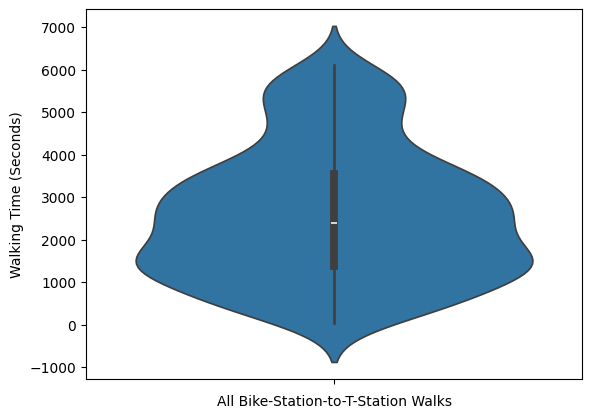

In [78]:
ax = sns.violinplot(data=all_walking_time)
ax.set(xlabel='All Bike-Station-to-T-Station Walks', ylabel='Walking Time (Seconds)')


In [170]:
# Goal dict:
# Dict of dicts
# {(bike_station_lat, bike_station_long): {(MBTA_station_lat1, MBTA_station_long1): walking_time_from_google_maps_api1, (MBTA_station_lat2, MBTA_station_long2): walking_time_from_google_maps_api2, etc}}

# Steps
### Create function that takes in a bike_station_name, bike_station_lat, and bike_station_long
### Finds walking time to each T station (calling Google Maps API)
### Finds minimum walking time
### Outputs a tuple (bike_station_name1, bike_station_lat1, bike_station_long1, walking_time_from_google_maps_api1) 

# Next
# Merge this df onto bike ride station

# Next
# Q: Repeat for end station? -- Do I need to recalculate walking time or can I assume it's the same both ways?

### Visualization

In [195]:
# Graph one: log travel time
bike_rides['log_travel_time_min'] = np.log(bike_rides['travel_time_min'])

In [215]:
bike_rides.columns

Index(['travel_time_sec', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'travel_time_min', 'log_travel_time_min'],
      dtype='object')

/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_49903/3792689030.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y='log_travel_time_min', data=bike_rides, palette='muted', cut=0)


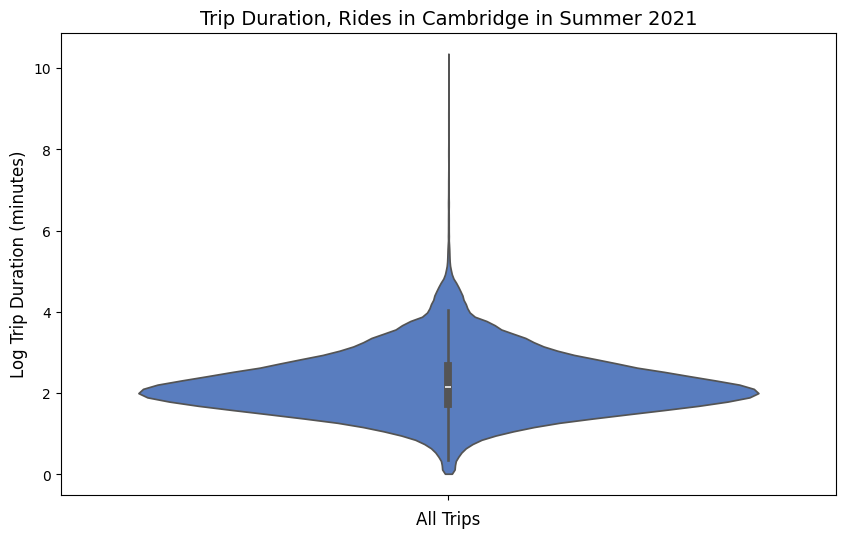

In [216]:
plt.figure(figsize=(10, 6))
sns.violinplot(y='log_travel_time_min', data=bike_rides, palette='muted', cut=0)
#plt.ylim(0, 60)  # Focus on trip durations up to 60 minutes
plt.title('Trip Duration, Rides in Cambridge in Summer 2021', fontsize=14)
plt.xlabel('All Trips', fontsize=12)
plt.ylabel('Log Trip Duration (minutes)', fontsize=12)
plt.show()